# Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

import os
from time import time

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Load data

In [2]:
class WarwickDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        # Directory of data
        self.images_dir = root_dir + split

        # Define tensor transformation
        self.transform = transforms.ToTensor()
        
        # Iterate over filenames in directory and store in sorted lists
        self.image_names = sorted([name for name in os.listdir(self.images_dir) if name.startswith('image_')])
        self.segmentation_names = sorted([name for name in os.listdir(self.images_dir) if name.startswith('label_')])

    def __len__(self):
        return len(self.image_names)  # Size of dataset

    def __getitem__(self, idx):
        # Get path
        img_path = self.images_dir + "/" + self.image_names[idx]
        segmentation_path = self.images_dir +  "/" + self.segmentation_names[idx]
        
        # Load image
        image = Image.open(img_path)
        segmentation = Image.open(segmentation_path)
        
        # Turn into tensor
        image = self.transform(image)
        label = self.transform(segmentation)

        return image, label

# Define Neural Network

In [3]:
class SegmentationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CONVOLUTION
        # Layer 1: 8 filters with dim=3x3x1 -> dim(Z1) = 128x128x8
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)

        # Layer 2: Max Pooling with dim=2x2 -> dim(Z2) = 64x64x8

        # Layer 3: 16 filters with dim=3x3x8 -> dim(Z3) = 64x64x16
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Layer 4: Max Pooling with dim=2x2 -> dim(Z4) = 32x32x16

        # Layer 5: 32 filters with dim=3x3x16 -> dim(Z5) = 32x32x32
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        
        # TRANSPOSED CONVOLUTION (Upsampling)
        # Layer 6: 16 filters with dim=4x4x32 -> dim(Z6) = 64x64x16
        self.convT6 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)

        # Layer 7: 16 filter with dim=4x4x16 -> dim(Z7) = 128x128x16
        self.convT7 = nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1)

        
        # 1x1 CONVOLUTION 
        # Layer 8: 2 filters with dim=1x1x16 -> dim(Z8) = 128x128x2
        self.conv8 = nn.Conv2d(16, 2, kernel_size=1)
        
        
        # Define other functions
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1) # Channel direction probabilities

    def forward(self, X):
        # Layer 1
        Z1 = self.conv1(X)
        A1 = self.relu(Z1)

        # Layer 2
        A2 = self.maxpool(A1)

        # Layer 3
        Z3 = self.conv3(A2)
        A3 = self.relu(Z3)

        # Layer 4
        A4 = self.maxpool(A3)

        # Layer 5
        Z5 = self.conv5(A4)
        A5 = self.relu(Z5)

        # Layer 6
        Z6 = self.convT6(A5)
        A6 = self.relu(Z6)

        # Layer 7
        Z7 = self.convT7(A6)
        A7 = self.relu(Z7)

        # Layer 8
        Z8 = self.conv8(A7)
        Y_hat = self.softmax(Z8)

        return Y_hat

# Accuracy function

In [4]:
def get_DSC(model_segmentation, true_segmentation):
    intersection = (model_segmentation * true_segmentation).sum().item()
    union = model_segmentation.sum().item() + true_segmentation.sum().item()

    dsc = (2 * intersection) / union

    return dsc

In [5]:
def get_DSC_vec(data_loader, model, device):
    DSC_vec = []
    
    model = model.to(device)

    # For each batch
    for data, true_segmentations in data_loader:
        data = data.to(device)
        true_segmentations = true_segmentations.to(device)
        
        raw_output = model(data)
        model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)

        # For each image in batch
        for i in range(data.shape[0]):
            model_seg = model_segmentations[i]
            true_seg = true_segmentations[i]

            DSC_vec.append(get_DSC(model_seg, true_seg))
    
    return DSC_vec

In [6]:
def get_average_DSC(data_loader, model, device):
    """ Get average DSC for all images in a data_loader """
    total_dsc = 0
    total_images = 0
    
    model = model.to(device)

    # For each batch
    for data, true_segmentations in data_loader:
        data = data.to(device)
        true_segmentations = true_segmentations.to(device)
        
        raw_output = model(data)
        model_segmentations = torch.argmax(raw_output, dim=1).unsqueeze(1)

        # For each image
        for i in range(data.shape[0]):
            model_seg = model_segmentations[i]
            true_seg = true_segmentations[i]

            dsc = get_DSC(model_seg, true_seg)
            total_dsc += dsc
            total_images += 1

    # Calculate average
    average_dsc = total_dsc / total_images
    
    return average_dsc

# Train model

In [8]:
def train_model(train_loader, test_loader, learning_rate,l2_strength, epochs, device, loss_vec, train_DSC_vec, test_DSC_vec):
    
    # Define model
    model = SegmentationCNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_strength)

    # Performance with random weights
    test_DSC = get_average_DSC(test_loader, model, device)
    print(f'Epoch [0/{epochs}],                                  , Test DSC: {test_DSC:.5f}')
    
    # Training loop
    for epoch in range(1, epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1).long()  # Fix format for loss function
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        # Save loss after every epoch
        loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        train_DSC = get_average_DSC([(data, labels)], model, device)
        train_DSC_vec.append(train_DSC)
        
        # Accuracy on all test data
        test_DSC = get_average_DSC(test_loader, model, device)
        test_DSC_vec.append(test_DSC)
            
        # Print epoch results
        if epoch%20==0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train DSC: {train_DSC:.5f}, Test DSC: {test_DSC:.5f}')
    
    return model, loss_vec, train_DSC, test_DSC


In [11]:
# Hyperparameters
batch_size = 16
epochs = 400
learning_rate = 0.001
params = [0, 0.0001, 0.001, 0.01, 0.1]



# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}\n")


# Load the dataset
root_dir = "C:/Users/edvin/GitHub/DeepImg/A3/WARWICK/"
train_dataset = WarwickDataset(root_dir, split='Train')
test_dataset = WarwickDataset(root_dir, split='Test')


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


# Result lists
all_loss = []
all_train_DSC = []
all_test_DSC = []


for l2_strength in params:
    print(f"\n\nTraining with L2 = {l2_strength}")
    
    # List for storing loss
    loss_vec = []
    train_DSC_vec = []
    test_DSC_vec = []

    # Train model
    start = time()
    model, loss_vec, train_DSC, test_DSC = train_model(train_loader, test_loader, learning_rate, l2_strength, epochs, device, loss_vec, train_DSC_vec, test_DSC_vec)
    print(f"\nTotal training time: {time()-start} seconds")
    
    # Save model performance
    all_loss.append(loss_vec)
    all_train_DSC.append(train_DSC_vec)
    all_test_DSC.append(test_DSC_vec)


Training on device: cuda



Training with L2 = 0
Epoch [0/400],                                  , Test DSC: 0.00000
Epoch [20/400], Loss: 0.59205, Train DSC: 0.72499, Test DSC: 0.60993
Epoch [40/400], Loss: 0.65323, Train DSC: 0.69807, Test DSC: 0.56782
Epoch [60/400], Loss: 0.54608, Train DSC: 0.63768, Test DSC: 0.58743
Epoch [80/400], Loss: 0.54612, Train DSC: 0.70364, Test DSC: 0.72727
Epoch [100/400], Loss: 0.48504, Train DSC: 0.74554, Test DSC: 0.71426
Epoch [120/400], Loss: 0.54200, Train DSC: 0.84133, Test DSC: 0.68213
Epoch [140/400], Loss: 0.50632, Train DSC: 0.70385, Test DSC: 0.73607
Epoch [160/400], Loss: 0.52203, Train DSC: 0.83456, Test DSC: 0.75033
Epoch [180/400], Loss: 0.47856, Train DSC: 0.71842, Test DSC: 0.59071
Epoch [200/400], Loss: 0.45915, Train DSC: 0.74245, Test DSC: 0.74658
Epoch [220/400], Loss: 0.47837, Train DSC: 0.81118, Test DSC: 0.75202
Epoch [240/400], Loss: 0.53229, Train DSC: 0.74305, Test DSC: 0.76887
Epoch [260/400], Loss: 0.46607, Train DSC: 0.78

# Print loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


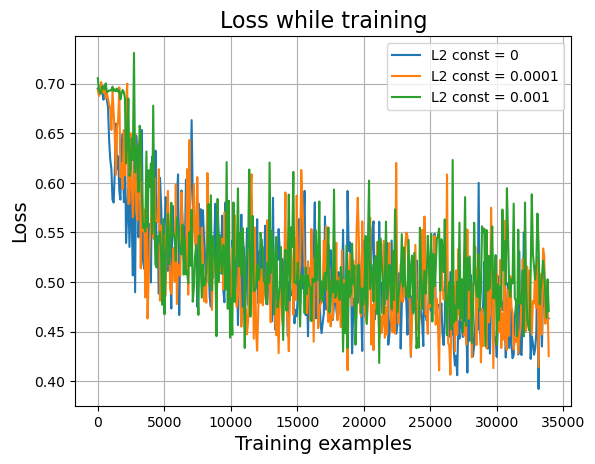

In [15]:
# Define data
x = range(0, len(loss_vec) * len(train_dataset), len(train_dataset))

# Define figure
fig1 = plt.figure()
plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Loss", fontsize=14) 

for i in range(len(params)-2):
    plt.plot(x,all_loss[i], label=f"L2 const = {params[i]}")

plt.legend()
plt.grid()
plt.title("Loss while training", fontsize=16) 
plt.savefig("Segmentation_Loss_regul.eps")

# Plot DSC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


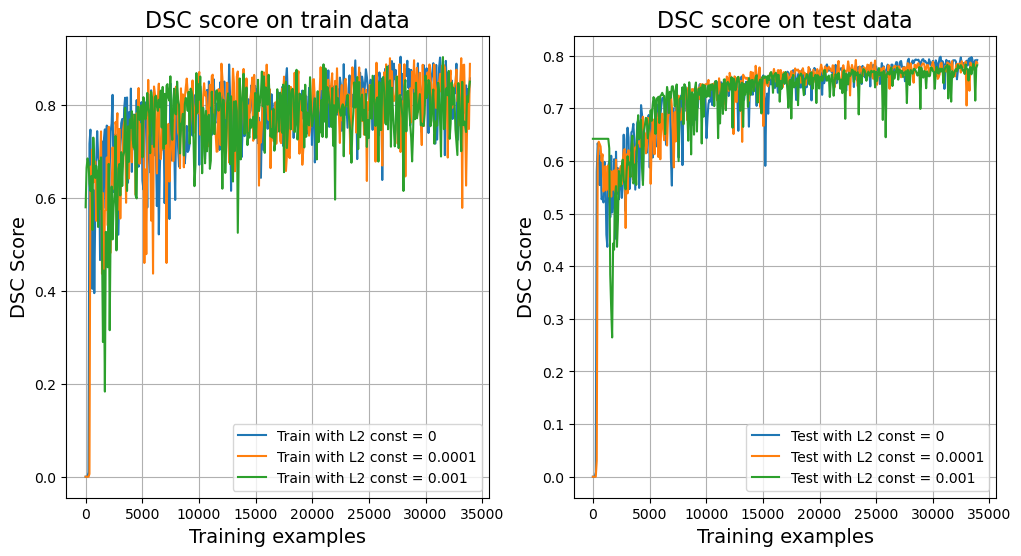

In [16]:
import matplotlib.pyplot as plt

# Define data
x = range(0, len(loss_vec) * len(train_dataset), len(train_dataset))

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot training DSC
for i in range(len(params)-2):
    ax1.plot(x, all_train_DSC[i], label=f"Train with L2 const = {params[i]}")

ax1.set_xlabel("Training examples", fontsize=14)
ax1.set_ylabel("DSC Score", fontsize=14)
ax1.legend()
ax1.grid()
ax1.set_title("DSC score on train data", fontsize=16)

# Plot testing DSC
for i in range(len(params)-2):
    ax2.plot(x, all_test_DSC[i], label=f"Test with L2 const = {params[i]}")

ax2.set_xlabel("Training examples", fontsize=14)
ax2.set_ylabel("DSC Score", fontsize=14)
ax2.legend()
ax2.grid()
ax2.set_title("DSC score on test data", fontsize=16)

# Save results
plt.savefig("Segmentation_DSC_regul.eps")
plt.show()
